<a href="https://colab.research.google.com/github/gagabriela2787/Grupo16_ISPC/blob/main/Grupo16Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GRUPO 16
# ***Proyecto: Detección tumoral de lunares***


---



In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/gdrive')

**1.   Comprensión del Negocio:**

Objetivo: Clasificar imágenes de lunares como benignos o malignos para ayudar en el diagnóstico médico.


**2.   Comprensión de los Datos:**
- Recolectar y explorar imágenes de lunares benignos y malignos.
- Verificar la estructura de los datos y la calidad de las imágenes.

In [ ]:
# Rutas de los datos
train_dir_benign = '/content/gdrive/MyDrive/dataset/train/benign/'
train_dir_malignant = '/content/gdrive/MyDrive/dataset/train/malignant/'
test_dir_benign = '/content/gdrive/MyDrive/dataset/test/benign/'
test_dir_malignant = '/content/gdrive/MyDrive/dataset/test/malignant/'

def show_sample_images(path, title):
    for img_name in os.listdir(path)[:5]:  # Mostrar solo 5 imágenes
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.show()

show_sample_images(train_dir_benign, 'Benign')
show_sample_images(train_dir_malignant, 'Malignant')


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/dataset/train/benign/'

**3. Preparación de los Datos:**
- Preprocesamiento de imágenes (redimensionar, normalizar).
- Creación de generadores de datos para entrenamiento y validación.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parámetros de imagen
img_size = 224  # Tamaño requerido por VGG16

# Crear generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% entrenamiento, 20% validación
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataset/train',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataset/train',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataset/test',
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary'
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


**4. Modelado:**
- Cargar el modelo VGG16 preentrenado.
- Añadir capas de clasificación en la parte superior.
- Compilar el modelo.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 preentrenado sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas de clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Añadir dropout para evitar overfitting
x = Dense(1, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 3s 0us/step


**5. Evaluación:**
- Entrenar el modelo con los datos de entrenamiento y validación.
- Evaluar el rendimiento del modelo en el conjunto de prueba.

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')


Epoch 1/10
66/66 [==============================] - 1829s 27s/step - loss: 0.5686 - accuracy: 0.7223 - val_loss: 0.4416 - val_accuracy: 0.7818
Epoch 2/10
66/66 [==============================] - 1745s 26s/step - loss: 0.4054 - accuracy: 0.8171 - val_loss: 0.5233 - val_accuracy: 0.7268
Epoch 3/10
66/66 [==============================] - 1759s 27s/step - loss: 0.3757 - accuracy: 0.8261 - val_loss: 0.4006 - val_accuracy: 0.8046
Epoch 4/10
 2/66 [..............................] - ETA: 22:45 - loss: 0.2757 - accuracy: 0.8750

**6. Despliegue:**
- Implementar el modelo en un entorno de producción.
- Crear una interfaz de usuario para subir imágenes y obtener predicciones.

In [ ]:
import tensorflow as tf

# Guardar el modelo entrenado
model.save('/content/gdrive/MyDrive/mole_classifier_vgg16.h5')

# Cargar y usar el modelo para predicciones
model = tf.keras.models.load_model('/content/gdrive/MyDrive/mole_classifier_vgg16.h5')

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return 'Malignant' if prediction[0][0] > 0.5 else 'Benign'

# Ejemplo de predicción
image_path = '/content/gdrive/MyDrive/dataset/test/benign/example.jpg'
print(predict_image(image_path))


# **# Desde esta sección en adelante son pruebas realizadas inicialmente**

---



In [ ]:
import cv2

# Carga la imagen
img = cv2.imread('/content/gdrive/MyDrive/dataset/data/train/benign/1009.jpg')

# Verifica que la imagen se haya cargado correctamente
if img is not None:
    # Obtiene las dimensiones de la imagen
    height, width, channels = img.shape

    # Imprime las dimensiones de la imagen
    print(f'Ancho: {width} píxeles')
    print(f'Alto: {height} píxeles')
    print(f'Número de canales: {channels}')
else:
    print('No se pudo cargar la imagen. Verifique la ruta del archivo.')


Ancho: 224 píxeles
Alto: 224 píxeles
Número de canales: 3


Cargar las imágenes y realizar el preprocesamiento

Dimensiones de datos: (660, 100, 100, 3)
Dimensiones de etiquetas: (660,)


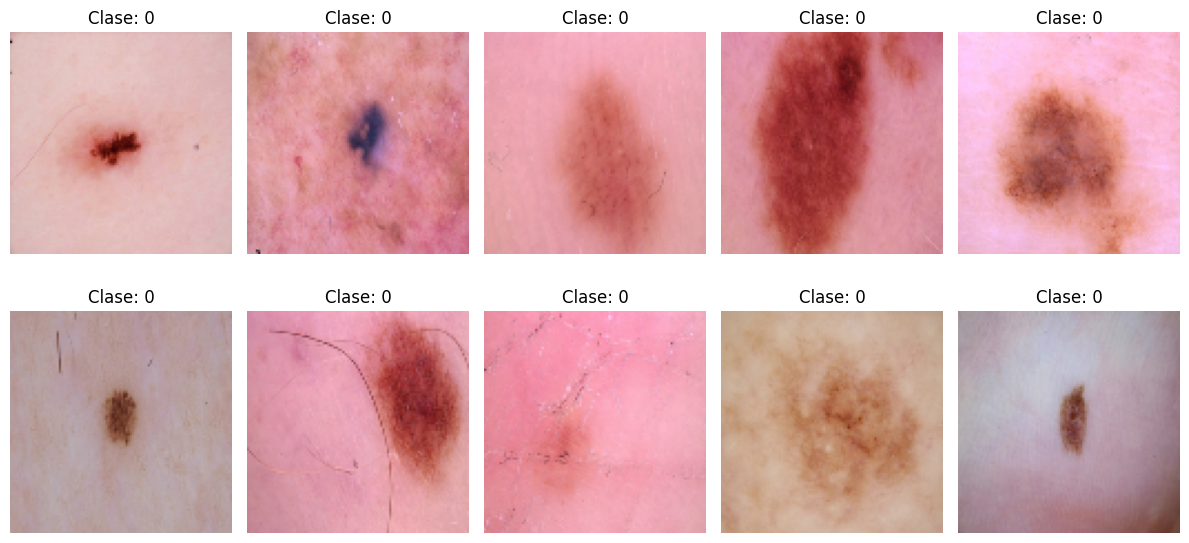

In [ ]:


# Directorios donde se encuentran las imágenes en Google Drive
directorio_benigno = '/content/gdrive/MyDrive/dataset/data/test/benign/'
directorio_maligno = '/content/gdrive/MyDrive/dataset/data/test/malignant/'

# Función para cargar las imágenes de un directorio
def cargar_imagenes(directorio, clase, img_size=(100, 100)):
    datos = []
    etiquetas = []
    for filename in os.listdir(directorio):
        path = os.path.join(directorio, filename)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
        img = cv2.resize(img, img_size)  # Cambiar tamaño de la imagen
        datos.append(img)
        etiquetas.append(clase)
    return datos, etiquetas

# Cargar las imágenes
datos_benignos, etiquetas_benignas = cargar_imagenes(directorio_benigno, 0)
datos_malignos, etiquetas_malignas = cargar_imagenes(directorio_maligno, 1)

# Convertir a arrays de NumPy
datos = np.array(datos_benignos + datos_malignos)
etiquetas = np.array(etiquetas_benignas + etiquetas_malignas)

# Normalizar los datos de píxeles
datos = datos / 255.0

# Verificar dimensiones y cantidad de datos
print('Dimensiones de datos:', datos.shape)
print('Dimensiones de etiquetas:', etiquetas.shape)

# Visualizar algunas imágenes de ejemplo
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(datos[i])
    plt.title(f'Clase: {etiquetas[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


Construcción de modelo CNN para clasificación

Epoch 1/10
17/17 [==============================] - 12s 578ms/step - loss: 0.7865 - accuracy: 0.5492 - val_loss: 0.6812 - val_accuracy: 0.6591
Epoch 2/10
17/17 [==============================] - 12s 702ms/step - loss: 0.5770 - accuracy: 0.7140 - val_loss: 0.5755 - val_accuracy: 0.7197
Epoch 3/10
17/17 [==============================] - 8s 466ms/step - loss: 0.4986 - accuracy: 0.7519 - val_loss: 0.6852 - val_accuracy: 0.6515
Epoch 4/10
17/17 [==============================] - 11s 662ms/step - loss: 0.4924 - accuracy: 0.7500 - val_loss: 0.4670 - val_accuracy: 0.7348
Epoch 5/10
17/17 [==============================] - 8s 499ms/step - loss: 0.4425 - accuracy: 0.7708 - val_loss: 0.4926 - val_accuracy: 0.7348
Epoch 6/10
17/17 [==============================] - 10s 558ms/step - loss: 0.5076 - accuracy: 0.7462 - val_loss: 0.7302 - val_accuracy: 0.4394
Epoch 7/10
17/17 [==============================] - 9s 565ms/step - loss: 0.5359 - accuracy: 0.7121 - val_loss: 0.4696 - val_accuracy: 0.7197
Ep

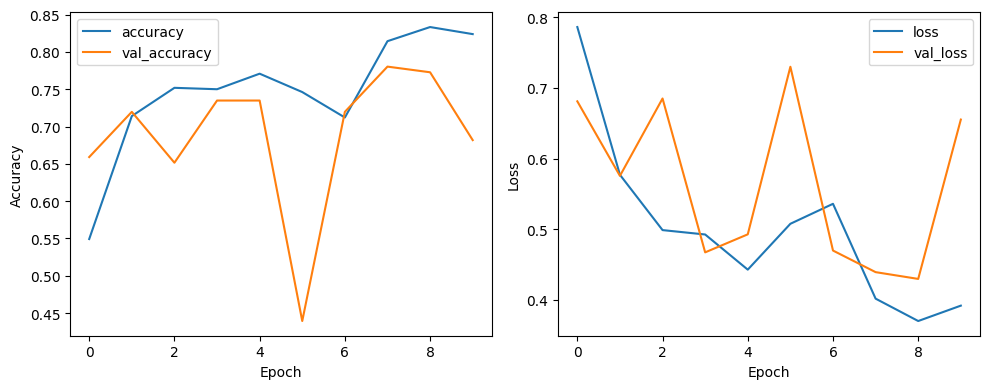

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos, etiquetas, test_size=0.2, random_state=42)

# Definir el modelo de CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nPrecisión en el conjunto de prueba:', test_acc)

# Plotear la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Explicación del código del modelo CNN
Definición del modelo: Se define una red neuronal convolucional básica con dos capas convolucionales y dos capas de pooling, seguidas de capas densas. La última capa utiliza una función de activación sigmoide para la clasificación binaria.

Compilación del modelo: Se utiliza el optimizador Adam y la función de pérdida de entropía cruzada binaria para la compilación del modelo.

Entrenamiento del modelo: El modelo se entrena durante 10 épocas con datos de entrenamiento y se valida con datos de prueba.

Evaluación del modelo: Se evalúa el modelo en el conjunto de prueba y se imprime la precisión.

Visualización del entrenamiento: Se grafican las métricas de precisión y pérdida durante el entrenamiento y validación.